Prediction model to predict if the client will subscribe a term deposit or not.

In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV 
from time import time
import scikitplot as skplt

In [4]:
df_train = pd.read_csv('train.csv')

In [5]:
df_test = pd.read_csv('test.csv')

In [92]:
df_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


In [7]:
df_test.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,38441,32,services,married,secondary,no,118,yes,no,cellular,15,may,20,6,-1,0,unknown
1,40403,78,retired,divorced,primary,no,2787,no,no,telephone,1,jul,372,1,-1,0,unknown
2,3709,31,self-employed,single,tertiary,no,144,yes,no,unknown,16,may,676,1,-1,0,unknown
3,37422,57,services,single,primary,no,3777,yes,no,telephone,13,may,65,2,-1,0,unknown
4,12527,45,blue-collar,divorced,secondary,no,-705,no,yes,unknown,3,jul,111,1,-1,0,unknown


In [8]:
df_train.isna().any()

ID            False
age           False
job           False
marital       False
education     False
default       False
balance       False
housing       False
loan          False
contact       False
day           False
month         False
duration      False
campaign      False
pdays         False
previous      False
poutcome      False
subscribed    False
dtype: bool

In [9]:
df_test.isna().any()

ID           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

Let's begin with EDA

In [14]:
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)

Text(0.5, 1.0, 'Jobs distribution plot')

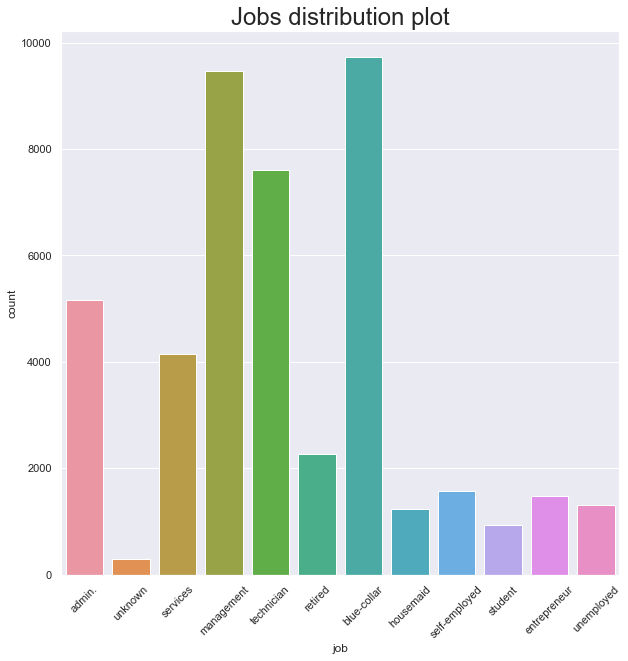

In [72]:
labels = df['job'].unique()
distplot = sns.countplot('job', data=df)
sns.set(rc={'figure.figsize':(10,10)}, font_scale=2)
distplot.set_xticklabels(rotation=45, labels=labels)
plt.title('Jobs distribution plot')

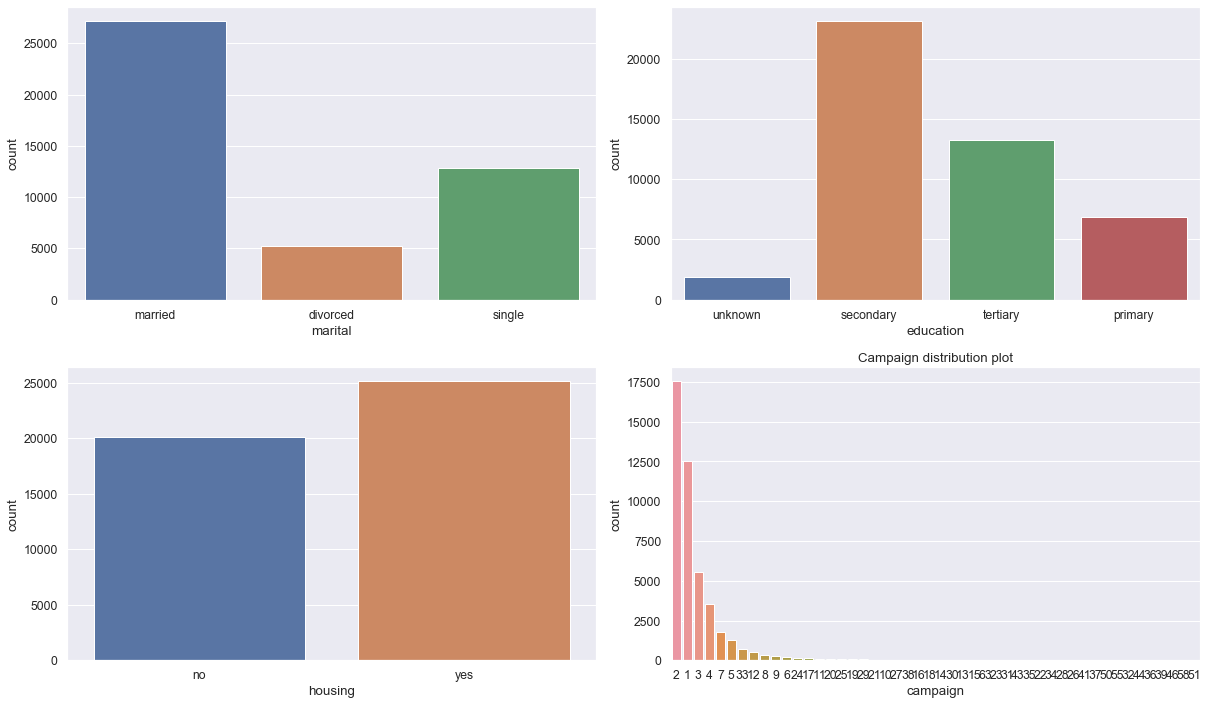

In [58]:
f, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.set(font_scale=1.1125)

distplot.set_xticklabels(rotation=45, labels=labels)
sns.countplot('marital', data=df, ax=ax[0][0])
plt.title('Marital distribution plot')

sns.countplot('education', data=df, ax=ax[0][1])
plt.title('Education distribution plot')

sns.countplot('housing', data=df, ax=ax[1][0])
plt.title('Housing distribution plot')

c_plot = sns.countplot('campaign', data=df, ax=ax[1][1])
plt.title('Campaign distribution plot')

plt.tight_layout()
plt.show()

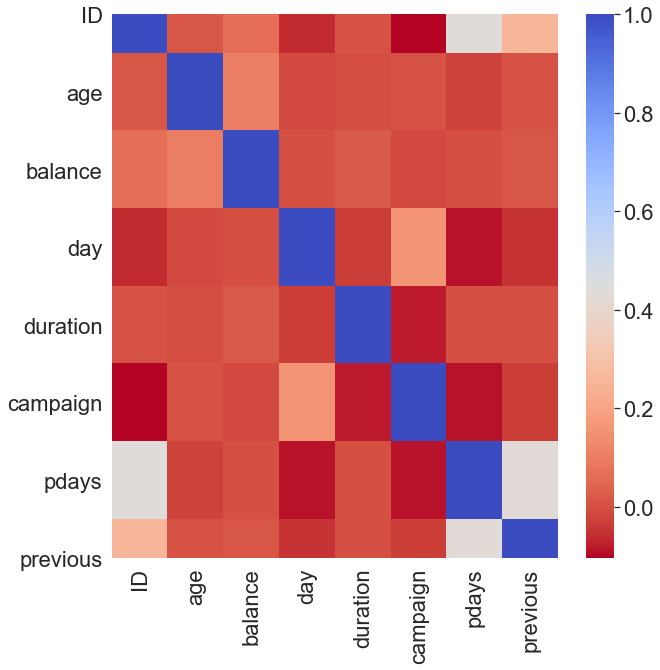

In [73]:
corr = df_train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':7})
plt.show()

[Text(0, 0, 'job'),
 Text(0, 0, 'marital'),
 Text(0, 0, 'education'),
 Text(0, 0, 'default'),
 Text(0, 0, 'balance'),
 Text(0, 0, 'housing'),
 Text(0, 0, 'contact'),
 Text(0, 0, 'day'),
 Text(0, 0, 'month'),
 Text(0, 0, 'duration'),
 Text(0, 0, 'campaign'),
 Text(0, 0, 'pdays'),
 Text(0, 0, 'previous'),
 Text(0, 0, 'poutcome'),
 Text(0, 0, 'subscribed')]

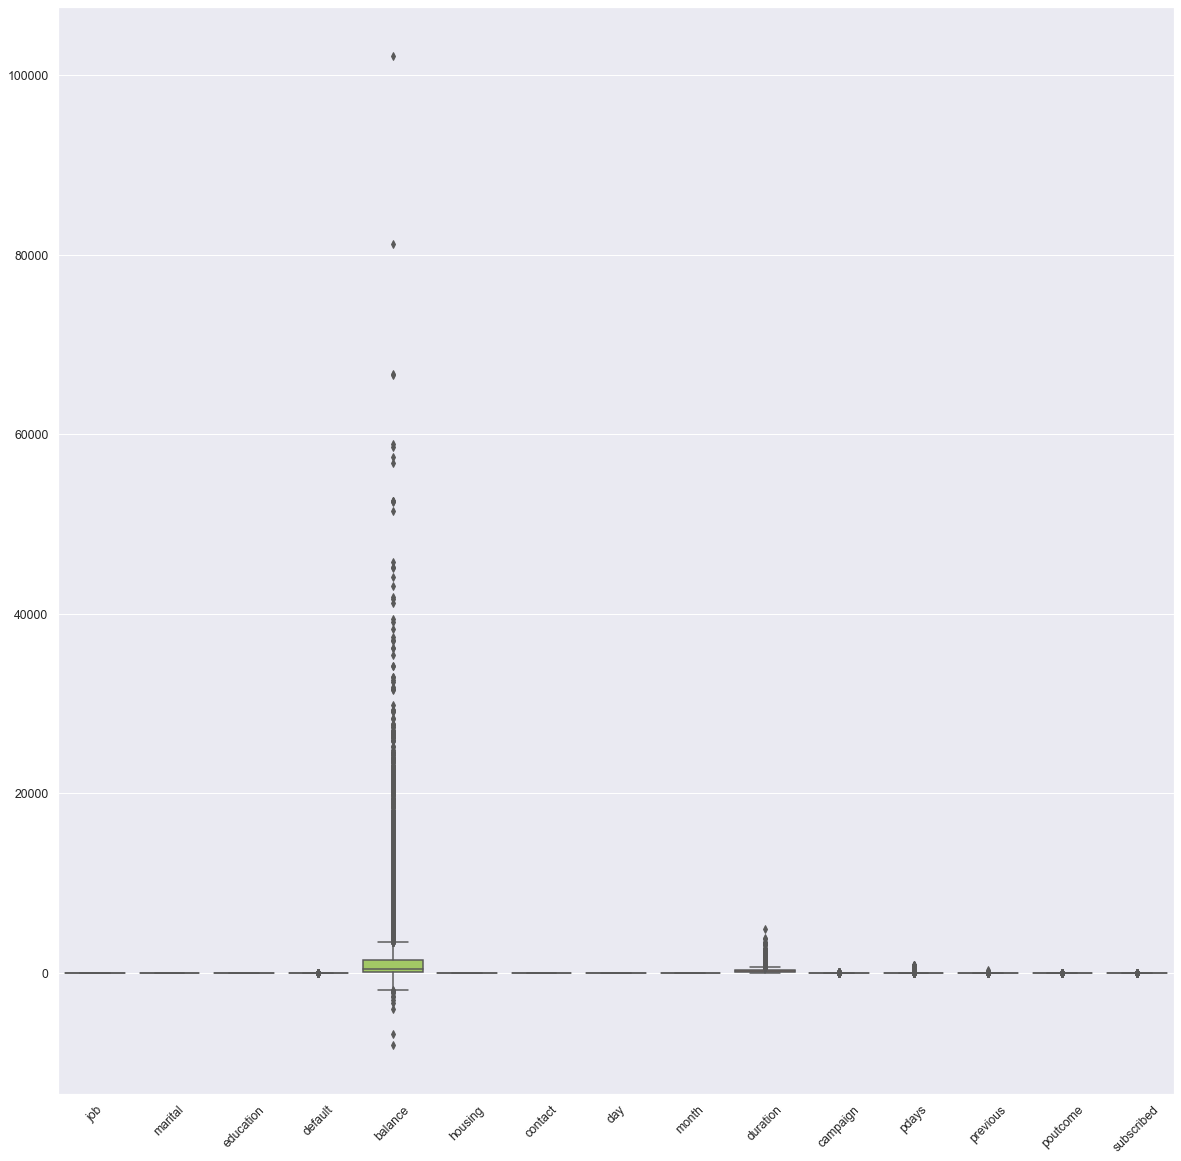

In [154]:
temp = df_train.iloc[:,2:].select_dtypes(include=['int64','float64'])
columns = list(temp.columns.values)
plt.figure(figsize=(20,20))
boxplot = sns.boxplot(data=df_train[columns], palette="Set2")
sns.set(font_scale=1.125)
boxplot.set_xticklabels(rotation=45, labels=temp.columns.values)

No fields, other than balance have significant outliers. 

In [75]:
print('Non Subscribed percentage is:', df_train['subscribed'].value_counts()[0]/len(df_train) * 100,'%')
print('Subscribed percentage is:', df_train['subscribed'].value_counts()[1]/len(df_train) * 100,'%')

Non Subscribed percentage is: 88.26113059689702 %
Subscribed percentage is: 11.73886940310298 %


In [79]:
df_train.shape

(31647, 18)

In [123]:
print('Number of rows in train set is:', df_train.shape[0])

Number of rows in train set is: 31647


In [133]:
le = LabelEncoder()
column_list = ['job', 'marital', 'education', 'default', 'month', 'contact', 'housing', 'poutcome', 'subscribed', 'loan']
for i in column_list:
    df_train[i] = le.fit_transform(df_train[i])

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:, 1:17], df_train['subscribed'], test_size=0.2, random_state=42)

In [135]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
18361,44,4,1,2,0,5282,1,0,2,30,8,274,1,-1,0,3
2232,54,4,1,2,0,184,0,0,0,6,3,13,6,-1,0,3
24219,29,8,2,1,0,314,0,0,0,30,0,465,1,-1,0,3
15644,32,0,2,2,0,3816,1,0,0,21,9,53,3,-1,0,3
8354,38,4,1,2,0,0,0,0,0,26,1,101,4,-1,0,3


C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicted confusion Matrix:
[[5402  197]
 [ 472  259]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5599
           1       0.57      0.35      0.44       731

    accuracy                           0.89      6330
   macro avg       0.74      0.66      0.69      6330
weighted avg       0.88      0.89      0.88      6330



C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


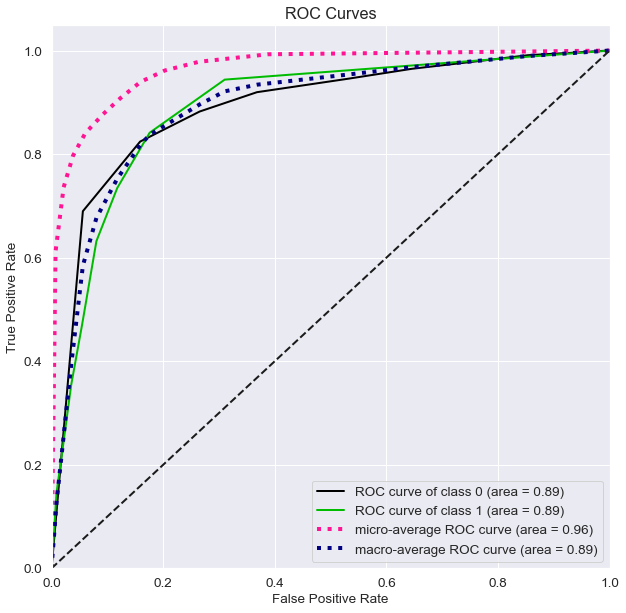

In [170]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)

predictions=rf.predict(X_test)
predictions_probab = rf.predict_proba(X_test)
cm=confusion_matrix(y_test, predictions)
print('Predicted confusion Matrix:')
print(cm)
print('')
print('Classification Report: ')
labels = ['0', '1']
print(classification_report(y_test, predictions, target_names=labels))
print('')
print('ROC Curve: ')
skplt.metrics.plot_roc_curve(y_test, predictions_probab)
plt.show()

Predicted confusion Matrix:
[[5444  155]
 [ 456  275]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5599
           1       0.64      0.38      0.47       731

    accuracy                           0.90      6330
   macro avg       0.78      0.67      0.71      6330
weighted avg       0.89      0.90      0.89      6330


ROC Curve:


C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


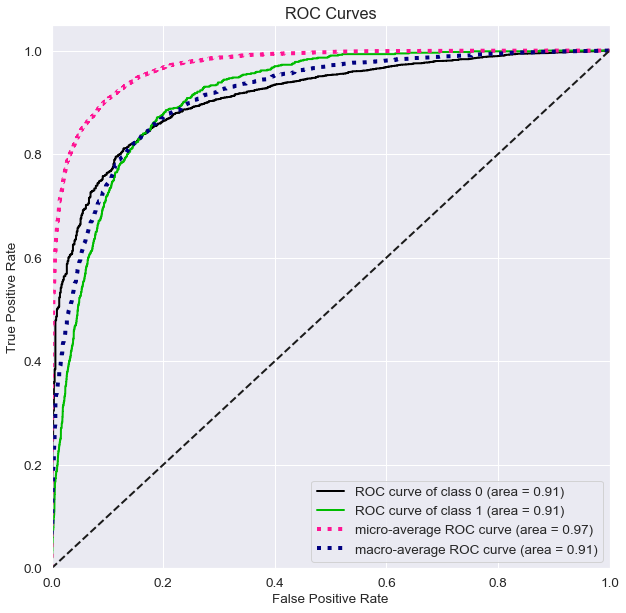

In [171]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

predictions_xgb=xgb.predict(X_test)
predictions_probab_xgb=xgb.predict_proba(X_test)
cm=confusion_matrix(y_test, predictions_xgb)
print('Predicted confusion Matrix:')
print(cm)
print('')
print('Classification Report: ')
labels = ['0', '1']
print(classification_report(y_test, predictions_xgb, target_names=labels))
print('')
print('ROC Curve:')
skplt.metrics.plot_roc_curve(y_test, predictions_probab_xgb)
plt.show()

Let's tweak the parameters using RandomizedSearchCV and optimize out prediction model. I will be doing it for XGBoost. 

In [157]:
param_grid = {'n_estimators': [10, 40, 60, 80, 100],
                    'learning_rate': [0.06, 0.02, 0.1, 0.15],
                    'gamma':  [0.03, 0.04, 0.05, 0.09],
                    'max_delta_step': [10, 20, 6, 8],
                    'max_depth':[2, 6, 10, 15]}       

In [160]:
start = time()
clf = RandomizedSearchCV(xgb, n_iter = 500, param_distributions=param_grid, cv=3, n_jobs=-1, verbose=2)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 58.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=500, n_jobs=-1,
                   param_distri

In [161]:
print("RandomizedSearchCV took %.2f seconds." % (time() - start))
clf.best_score_, clf.best_params_

RandomizedSearchCV took 3562.51 seconds.


(0.9072164948453608,
 {'n_estimators': 100,
  'max_depth': 6,
  'max_delta_step': 10,
  'learning_rate': 0.1,
  'gamma': 0.05})

Predicted confusion Matrix:
[[5389  210]
 [ 396  335]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5599
           1       0.61      0.46      0.53       731

    accuracy                           0.90      6330
   macro avg       0.77      0.71      0.74      6330
weighted avg       0.89      0.90      0.90      6330


ROC Curve:


C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


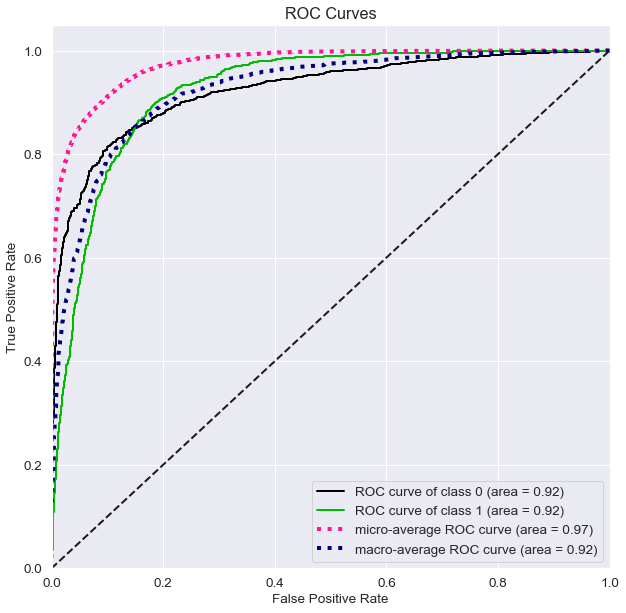

In [173]:
xgb = XGBClassifier(n_estimators=100, max_depth=6, max_delta_step=10, learning_rate=0.1, gamma=0.05)
xgb.fit(X_train, y_train)

predictions_xgb=xgb.predict(X_test)
predictions_probab_xgb=xgb.predict_proba(X_test)
cm=confusion_matrix(y_test, predictions_xgb)
print('Predicted confusion Matrix:')
print(cm)
print('')
print('Classification Report: ')
labels = ['0', '1']
print(classification_report(y_test, predictions_xgb, target_names=labels))
print('')
print('ROC Curve:')
skplt.metrics.plot_roc_curve(y_test, predictions_probab_xgb)
plt.show()